## Import libraries

In [0]:
import keras
from keras import layers
from keras import backend as K
from keras import models
import numpy as np

## Initial setup

In [0]:
img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2              # Dimensionality of the latent space: a 2D plane

# VAE Encoder network

In [0]:
input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3, padding='same', activation='relu', strides=(2,2))(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)

shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

## Latent space sampling

In [0]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

# VAE Decoder network, mapping latent space points to images

In [0]:
decoded_input = layers.Input(K.int_shape(z)[1:])  # Excludnig the batch dim in shape

x = layers.Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoded_input)
x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2,2))(x)
x = layers.Conv2D(1, 3, padding='same', activation='sigmoid')(x)

decoder = models.Model(decoded_input, x)
z_decoded = decoder(z)

# Custom layer used to compute the VAE loss

In [0]:
class CustomVariationalLayer(keras.layers.Layer):
    
    def vae_loss(self, x, z_decoded):
      x = K.flatten(x)
      z_decoded = K.flatten(z_decoded)
      xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
      kl_loss = -5e-4 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
      return K.mean(xent_loss + kl_loss)
    
    def call(self, inputs):
      x = inputs[0]
      z_decoded = inputs[1]
      loss = self.vae_loss(x, z_decoded)
      self.add_loss(loss, inputs=inputs)
      return x  # We won't use this, but something has to be returned
    
y = CustomVariationalLayer()([input_img, z_decoded])

# Training the VAE

In [11]:
from keras.datasets import mnist

vae = models.Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Output "custom_variational_layer_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_1" during training.
  after removing the cwd from sys.path.


In [12]:
(x_train, _), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

In [14]:
vae.fit(x=x_train, y=None,
        shuffle=True,
        epochs=10,
        batch_size=batch_size,
        validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
48144/60000 [=======================>......] - ETA: 11s - loss: 0.2290

60000/60000 [==============================] - 60s 1ms/step - loss: 0.2230 - val_loss: 0.1966
Epoch 2/10
31552/60000 [==============>...............] - ETA: 26s - loss: 0.1942

60000/60000 [==============================] - 58s 961us/step - loss: 0.1927 - val_loss: 0.1895
Epoch 3/10
24688/60000 [===========>..................] - ETA: 32s - loss: 0.1894

60000/60000 [==============================] - 58s 961us/step - loss: 0.1884 - val_loss: 0.1859
Epoch 4/10
21856/60000 [=========>....................] - ETA: 35s - loss: 0.1861

60000/60000 [==============================] - 58s 963us/step - loss: 0.1860 - val_loss: 0.1841
Epoch 5/10
20832/60000 [=========>....................] - ETA: 36s - loss: 0.1843

60000/60000 [==============================] - 58s 966us/step - loss: 0.1843 - val_loss: 0.1848
Epoch 6/10
20352/60000 [=========>....................] - ETA: 36s - loss: 0.1831

60000/60000 [==============================] - 58s 963us/step - loss: 0.1832 - val_loss: 0.1822
Epoch 7/10
20160/60000 [=========>....................] - ETA: 36s - loss: 0.1820

60000/60000 [==============================] - 58s 966us/step - loss: 0.1822 - val_loss: 0.1816
Epoch 8/10
20080/60000 [=========>....................] - ETA: 36s - loss: 0.1814

60000/60000 [==============================] - 58s 967us/step - loss: 0.1814 - val_loss: 0.1820
Epoch 9/10
20000/60000 [=========>....................] - ETA: 36s - loss: 0.1798

60000/60000 [==============================] - 58s 963us/step - loss: 0.1808 - val_loss: 0.1830
Epoch 10/10
19968/60000 [========>.....................] - ETA: 36s - loss: 0.1806

60000/60000 [==============================] - 57s 957us/step - loss: 0.1801 - val_loss: 0.1820


In [0]:
vae.save('model.h5')

In [0]:
from google.colab import files
files.download('model.h5')

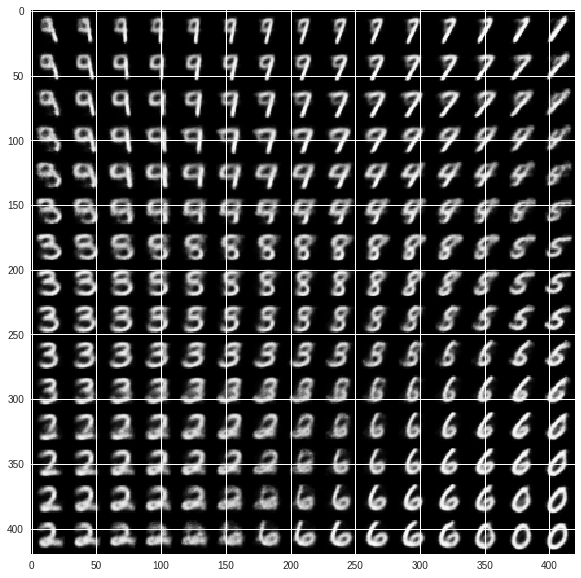

In [18]:
import matplotlib.pyplot as plt
from scipy.stats import norm

n = 15
digit_size = 28

figure = np.zeros((digit_size * n, digit_size * n))

grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
  for j, xi in enumerate(grid_y):
    z_sample = np.array([[xi, yi]])
    z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
    x_decoded = decoder.predict(z_sample, batch_size=batch_size)
    digit = x_decoded[0].reshape(digit_size, digit_size)
    figure[i * digit_size: (i + 1) * digit_size, j * digit_size: (j + 1) * digit_size] = digit
    
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()